# KNN (K-Nearest-Neighbors)

KNN is a simple concept: define some distance metric between the items in your dataset, and find the K closest items. You can then use those items to predict some property of a test item, by having them somehow "vote" on it.

As an example, let's look at the MovieLens data. We'll try to guess the rating of a movie by looking at the 10 movies that are closest to it in terms of genres and popularity.

To start, we'll load up every rating in the data set into a Pandas DataFrame:

In [1]:
import pandas as pd

r_cols = ['user_id', 'movie_id', 'rating']
ratings = pd.read_csv('/Users/ddarios/udemy/machine_learning/DataScience-Python3/ml-100k/u.data', sep='\t', names=r_cols, usecols=range(3))
ratings.head()


,user_id,movie_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3


Now, we'll group everything by movie ID, and compute the total number of ratings (each movie's popularity) and the average rating for every movie:

In [2]:
import numpy as np

movieProperties = ratings.groupby('movie_id').agg({'rating': [np.size, np.mean]})
movieProperties.head()

rating          
           size      mean
movie_id                 
1           452  3.878319
2           131  3.206107
3            90  3.033333
4           209  3.550239
5            86  3.302326

In [8]:
movieNumRatings = pd.DataFrame(movieProperties['rating']['size'])
movieNormalizedNumRatings = movieNumRatings.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
movieNormalizedNumRatings.head()

,size
movie_id,
1,0.773585
2,0.222985
3,0.152659
4,0.356775
5,0.145798


The raw number of ratings isn't very useful for computing distances between movies, so we'll create a new DataFrame that contains the normalized number of ratings. So, a value of 0 means nobody rated it, and a value of 1 will mean it's the most popular movie there is.

Now, let's get the genre information from the u.item file. The way this works is there are 19 fields, each corresponding to a specific genre - a value of '0' means it is not in that genre, and '1' means it is in that genre. A movie may have more than one genre associated with it.

While we're at it, we'll put together everything into one big Python dictionary called movieDict. Each entry will contain the movie name, list of genre values, the normalized popularity score, and the average rating for each movie:

In [9]:
movieDict = {}
with open(r'/Users/ddarios/udemy/machine_learning/DataScience-Python3/ml-100k/u.item', encoding = "ISO-8859-1") as f:
    temp = ''
    for line in f:
        #line.decode("ISO-8859-1")
        fields = line.rstrip('\n').split('|')
        movieID = int(fields[0])
        name = fields[1]
        genres = fields[5:25]
        genres = map(int, genres)
        movieDict[movieID] = (name, np.array(list(genres)), movieNormalizedNumRatings.loc[movieID].get('size'), movieProperties.loc[movieID].rating.get('mean'))


For example, here's the record we end up with for movie ID 1, "Toy Story":

In [10]:
print(movieDict[1])

('Toy Story (1995)', array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 0.77358490566037741, 3.8783185840707963)


Now let's define a function that computes the "distance" between two movies based on how similar their genres are, and how similar their popularity is. Just to make sure it works, we'll compute the distance between movie ID's 2 and 4:

In [11]:
from scipy import spatial

def ComputeDistance(a, b):
    genresA = a[1]
    genresB = b[1]
    genreDistance = spatial.distance.cosine(genresA, genresB)
    popularityA = a[2]
    popularityB = b[2]
    popularityDistance = abs(popularityA - popularityB)
    return genreDistance + popularityDistance
    
ComputeDistance(movieDict[2], movieDict[4])



0.80045740423098921

Remember the higher the distance, the less similar the movies are. Let's check what movies 2 and 4 actually are - and confirm they're not really all that similar:

In [12]:
print(movieDict[2])
print(movieDict[4])

('GoldenEye (1995)', array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 0.22298456260720412, 3.2061068702290076)
('Get Shorty (1995)', array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 0.35677530017152659, 3.5502392344497609)


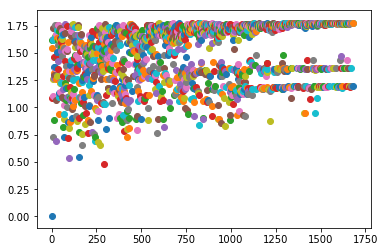

In [17]:
%matplotlib inline
from pylab import *
import pylab as pl

target_ids = range(len(movieDict))
# pl.figure()
for i in movieDict:
    dist = ComputeDistance(movieDict[1], movieDict[i])
    pl.scatter(i, dist)
pl.show()

Now, we just need a little code to compute the distance between some given test movie (Toy Story, in this example) and all of the movies in our data set. When the sort those by distance, and print out the K nearest neighbors:

In [37]:
import operator

def getNeighbors(movieID, K):
    distances = []
    for movie in movieDict:
        if (movie != movieID):
            dist = ComputeDistance(movieDict[movieID], movieDict[movie])
            distances.append((movie, dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(K):
        neighbors.append(distances[x][0])
    return neighbors

K = 10
avgRating = 0
neighbors = getNeighbors(1, K)
for neighbor in neighbors:
    avgRating += movieDict[neighbor][3]
    print (movieDict[neighbor][0] + " " + str(movieDict[neighbor][3]))
    
avgRating /= K

Liar Liar (1997) 3.15670103093
Aladdin (1992) 3.81278538813
Willy Wonka and the Chocolate Factory (1971) 3.63190184049
Monty Python and the Holy Grail (1974) 4.0664556962
Full Monty, The (1997) 3.92698412698
George of the Jungle (1997) 2.68518518519
Beavis and Butt-head Do America (1996) 2.78846153846
Birdcage, The (1996) 3.44368600683
Home Alone (1990) 3.08759124088
Aladdin and the King of Thieves (1996) 2.84615384615


While we were at it, we computed the average rating of the 10 nearest neighbors to Toy Story:

In [38]:
avgRating

3.3445905900235564

How does this compare to Toy Story's actual average rating?

In [39]:
movieDict[1]

('Toy Story (1995)',
 array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0.77358490566037741,
 3.8783185840707963)

Not too bad!


## Activity

Our choice of 10 for K was arbitrary - what effect do different K values have on the results?

Our distance metric was also somewhat arbitrary - we just took the cosine distance between the genres and added it to the difference between the normalized popularity scores. Can you improve on that?